# **使用scharr算子提取lena的边缘**

## **OpenCV Scharr**

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

原始图像尺寸：(400, 400, 3)


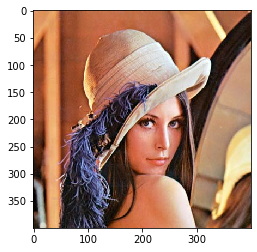

In [2]:
img = cv2.imread("./lena.jpg")
plt.imshow(img[:,:,::-1])
print("原始图像尺寸：{}".format(img.shape))

### **RGB2Geay**

灰度图尺寸：(400, 400)


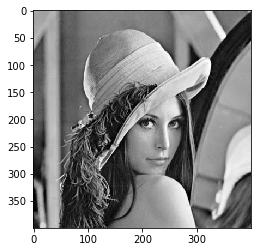

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
print("灰度图尺寸：{}".format(gray.shape))

In [4]:
import time

start_time = time.time()

scharr_x=cv2.Scharr(gray, cv2.CV_64F, 1, 0)
scharr_y=cv2.Scharr(gray, cv2.CV_64F, 0, 1)
scharr_res = np.clip(scharr_x + scharr_y, 0, 255)

end_time = time.time()

print("耗时：{}s".format(end_time-start_time))

耗时：0.05850028991699219s


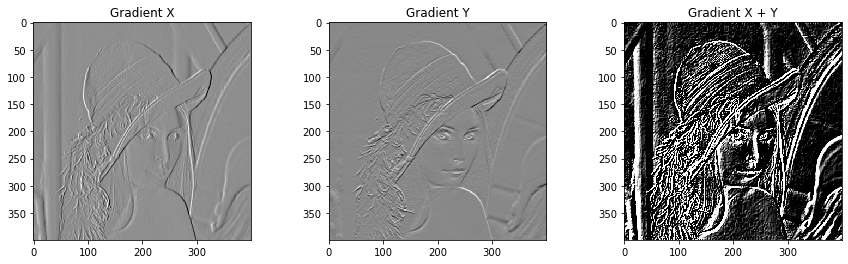

In [5]:
fig_scharr3 = plt.figure()
fig_scharr3.set_figheight(4)
fig_scharr3.set_figwidth(15)
# gradient x
fig_1 = fig_scharr3.add_subplot(131)
fig_1.title.set_text('Gradient X')
plt.imshow(scharr_x,cmap='gray')
# gradient y
fig_2 = fig_scharr3.add_subplot(132)
fig_2.title.set_text('Gradient Y')
plt.imshow(scharr_y,cmap='gray')
# gradient
fig_3 = fig_scharr3.add_subplot(133)
fig_3.title.set_text('Gradient X + Y')
plt.imshow(scharr_res,cmap='gray')

## **Hardware Scharr**

### **方法1：直接调用**

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [6]:
from pynq import Overlay, allocate

overlay = Overlay("./overlay_axis/scharr.bit")

scharr = overlay.scharr_0

rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

In [7]:
scharr.write(0x10, rows)
scharr.write(0x18, cols)

scharr.register_map.rows = rows
scharr.register_map.cols = cols

In [8]:
scharr.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

In [9]:
dma = overlay.axi_dma_0

In [10]:
import time

scharr.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.012145519256591797s


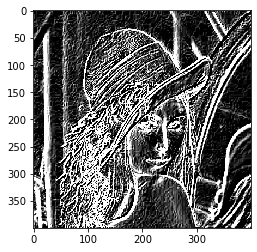

In [11]:
plt.imshow(output_buffer.reshape(rows, cols), cmap='gray')

### **方法2：为IP创建一个Driver**

In [12]:
from pynq import DefaultIP

class ScharrDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:scharr:1.0']

    def scharr3x3(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res

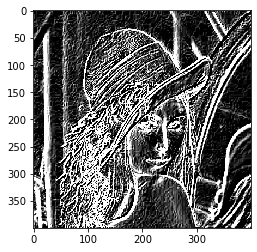

In [14]:
overlay = Overlay("./overlay_axis/scharr.bit")
dma = overlay.axi_dma_0
scharr = overlay.scharr_0
res = scharr.scharr3x3(input_buffer, output_buffer, rows, cols)
plt.imshow(res, cmap='gray')